In [4]:
import os
import json
import model
import data
from argparse import Namespace
import torch
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

def get_model(model_dir):
    with open(os.path.join(model_dir, 'args.json'), 'r') as f:
        model_args = Namespace(**json.load(f))

    encoder_model = model.BertEncoder(model_args.utt_dims,
            from_pretrained=False, finetune_bert=False,
            resize=len(tokenizer))
    encoder_model_file = os.path.join(model_dir, f'encoder_model.E{model_args.epochs-1}.bin')

    encoder_model.load_state_dict(torch.load(encoder_model_file))
    encoder_model.eval()
    return encoder_model, model_args

def get_test_data(model_args):
    tag_vocab_file = os.path.join(model_args.data_dir, f'{model_args.corpus}_tags.txt')
    tag_vocab, tag2id = data.load_tag_vocab(tag_vocab_file)
    test_file = os.path.join(model_args.data_dir, f'{model_args.corpus}_test.json')
    test_data = data.load_data(test_file, tokenizer, tag2id, strip_laughter=model_args.no_laughter)
    return test_data, tag_vocab
    
def get_laughs(encoder_model, test_data, tag_vocab):
    laughs = []
    laugh_vectors = []
    for dialogue_id, (dialogue, tags) in enumerate(test_data):
        print('.',end='')
        for utt_id, (utt, tag) in enumerate(zip(dialogue, tags)):
            laugh_idxs = [i for i,w in enumerate(utt) if w==laugh_id]
            if laugh_idxs: # if there are any laughs
                with torch.no_grad():
                    utt = torch.LongTensor(utt).unsqueeze(0)
                    hidden, _ = encoder_model.bert(utt)
                for laugh_idx in laugh_idxs:
                    laughs.append({
                        'dialogue_id': dialogue_id,
                        'utt_id': utt_id,
                        'tag': tag_vocab[tag],
                    })
                    laugh_vectors.append(list(hidden[0,laugh_idx]))
    laughs = pd.DataFrame(laughs)
    laugh_vectors = np.array(laugh_vectors)
    
    return laughs, laugh_vectors

In [2]:
import matplotlib.pyplot as plt

def plot_laughs(ax, laughs, laugh_vectors, corpus='SWDA'):
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(laugh_vectors)
    laughs['PCA1'] = pcs[:,0]
    laughs['PCA2'] = pcs[:,1]
    
    with open(os.path.join(f'analysis/ACL/{corpus}_dialogue-acts-groups.json'), 'r') as f:
        tag_groups = json.load(f)
    laughs['tag_group'] = laughs['tag'].apply(lambda x: tag_groups.get(x, None))
    cmap = dict(zip(set(tag_groups.values()), plt.get_cmap('Set1').colors))
    
    for group in set(tag_groups.values()):
        laughs[laughs.tag_group==group].plot.scatter(x='PCA1', y='PCA2', c=[cmap[group]], label=group, ax=ax, figsize=(20,10))

In [5]:
tokenizer = data.load_tokenizer('bert-base-uncased')
laugh_id = tokenizer.convert_tokens_to_ids(data.LAUGHTER_TOKEN)

SWDA_dir = "/scratch/DistributionalDiscourse/models/SWDA-L_bert_AMI+SWBD-pre_2019-12-03/"

SWDA_model, SWDA_args = get_model(SWDA_dir)
SWDA_data, SWDA_tags = get_test_data(SWDA_args)
SWDA_laughs, SWDA_laugh_vecs = get_laughs(SWDA_model, SWDA_data, SWDA_tags)

........................................................................................................................................................................................................................................

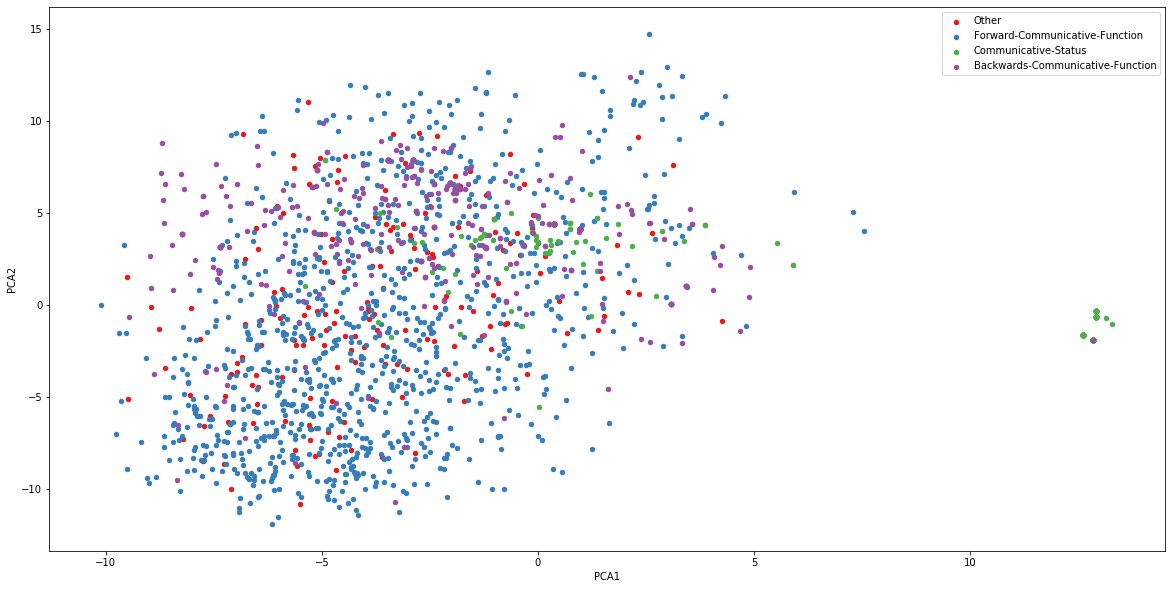

In [6]:
ax = plt.axes()
plot_laughs(ax, SWDA_laughs, SWDA_laugh_vecs, corpus='SWDA')

In [7]:
for i, row in SWDA_laughs.iterrows():
    if row['PCA1'] > 10:
        utt = SWDA_data[row.dialogue_id][0][row.utt_id]
        utt_str = ' '.join(tokenizer.convert_ids_to_tokens(utt))
        print(f'{row.tag} {utt_str}')

x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_A] # <laughter> . # [SEP]
x [CLS] [SPKR_B] # <laughter> . # [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_A] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_A] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] # <laughter> . # [SEP]
x [CLS] [SPKR_A] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_B] <laughter> . [SEP]
x [CLS] [SPKR_A] # <laughter> . # [SEP]
x [CLS] [SPKR_A] <laughter> . [SEP]
x [CLS] [SPKR_A] <laughter> . [SEP]
x [CLS] [SPK

In [8]:
AMI_dir = "/scratch/DistributionalDiscourse/models/AMI-DA-L_bert_AMI+SWBD-pre_2019-12-03/"

AMI_model, AMI_args = get_model(AMI_dir)
AMI_data, AMI_tags = get_test_data(AMI_args)
AMI_laughs, AMI_laugh_vecs = get_laughs(AMI_model, AMI_data, AMI_tags)

.............................

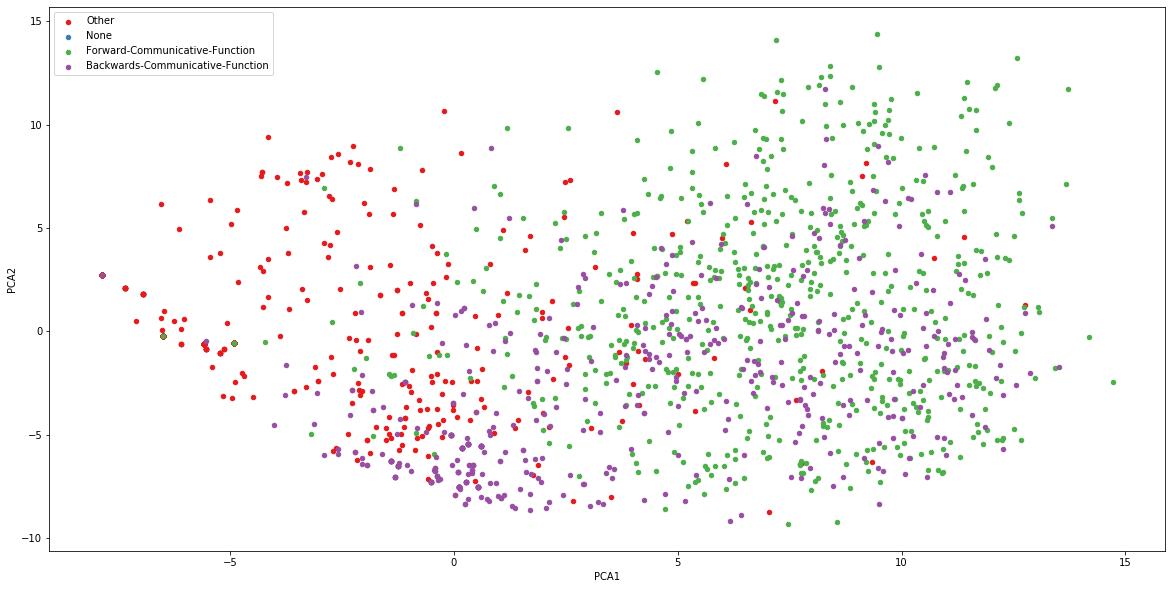

In [9]:
ax = plt.axes()
plot_laughs(ax, AMI_laughs, AMI_laugh_vecs, corpus='AMI-DA')

In [10]:
for i, row in AMI_laughs.iterrows():
    if row['PCA1'] > 10 and row['PCA2'] < -5:
        utt = AMI_data[row.dialogue_id][0][row.utt_id]
        utt_str = ' '.join(tokenizer.convert_ids_to_tokens(utt))
        print(f'{row.tag} {utt_str}')

ami_da_14 [CLS] [SPKR_B] great . <laughter> [SEP]
ami_da_4 [CLS] [SPKR_C] hope so . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_B] thank you . <laughter> [SEP]
ami_da_9 [CLS] [SPKR_C] we ' re not too hard on ourselves . <laughter> [SEP]
ami_da_9 [CLS] [SPKR_D] <laughter> alright , great . [SEP]
ami_da_9 [CLS] [SPKR_D] <laughter> unbelievable . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_C] <laughter> you ' re fired . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_C] bless you . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_C] <laughter> a happy ho ##l happy holidays . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_C] <laughter> a happy ho ##l happy holidays . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_A] <laughter> mm great . <laughter> [SEP]
ami_da_14 [CLS] [SPKR_A] <laughter> mm great . <laughter> [SEP]
ami_da_6 [CLS] [SPKR_D] <laughter> the remote that knows you . <laughter> [SEP]
ami_da_6 [CLS] [SPKR_D] <laughter> the remote that knows you . <laughter> [SEP]
ami_da_9 [CLS] [SPKR_B] <laughter> sheep . yeah , [SEP]
ami_